# Timescale Estimation Demo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cmocean
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

Load sample time series from a random participant.

In [3]:
ts_df = pd.read_csv('/home/despoB/nki_rs/data/derivatives/custom/sub-A00008326/func/sub-A00008326_ses-DS2_task-rest_acq-1400_bold_space-T1w_atlas-BNA_variant-CompCor_timeseries.tsv', delimiter='\t', header=None)

### Lag-1 Autocorrelation

Calculate and plot lag-1 autocorrelation for all ROIs.

In [6]:
sns.set_style('ticks')
sns.set_context('notebook')

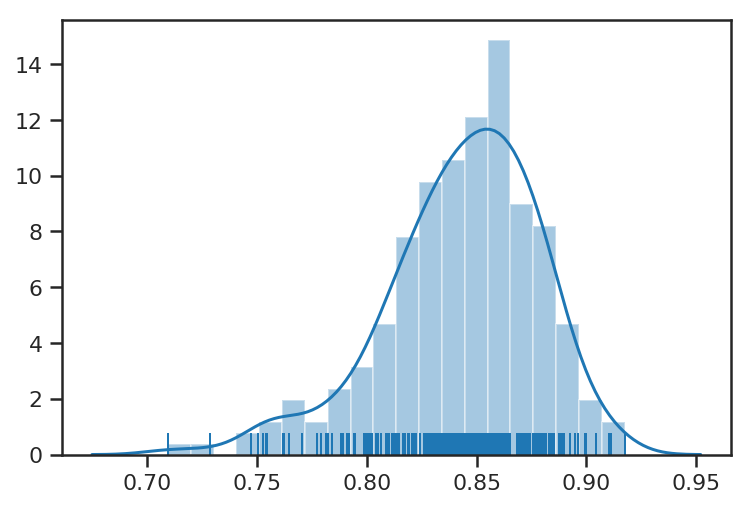

In [7]:
lag1_array = []
for ROI in range(246):
    lag1_array.append(pd.Series.autocorr(ts_df[ROI], 1))
    
f = sns.distplot(lag1_array, bins=20, rug=True)

### Autocorrelation Function

Calculate the autocorrelation function across lags.

In [8]:
def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(ts, lag))
    return ac_array

Plot autocorrelation decays for all ROIs.

Caclculate lags up to 80 volumes (~111 seconds, which is the period of the minimum frequency we can detect given a 0.009 Hz high pass filter)

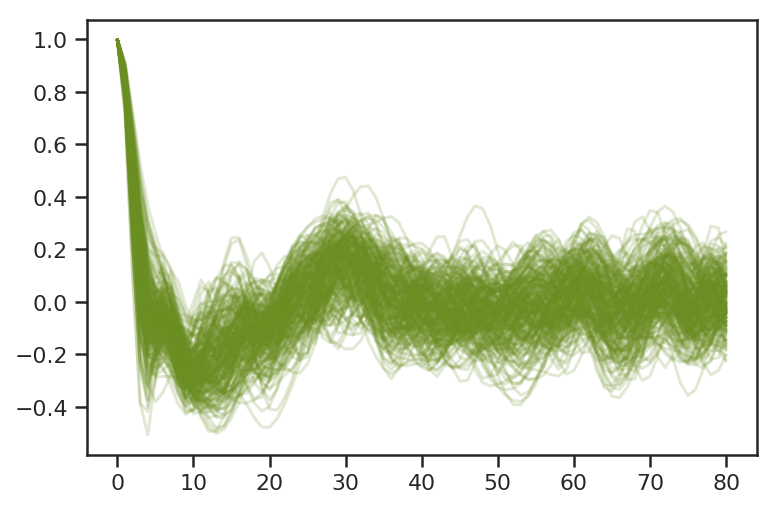

In [9]:
for ROI in range(246):
    plt.plot(range(81), autocorr_range(ts_df[ROI], range(81)), alpha=0.2, color='olivedrab')

Focus only on lags up to 20.

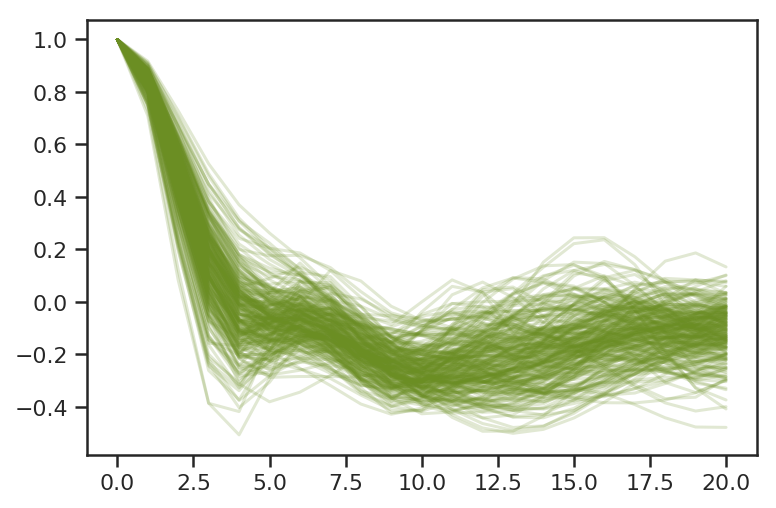

In [10]:
for ROI in range(246):
    plt.plot(range(21), autocorr_range(ts_df[ROI], range(21)), alpha=0.2, color='olivedrab')

Let's zoom in even more on the first 10 lags.

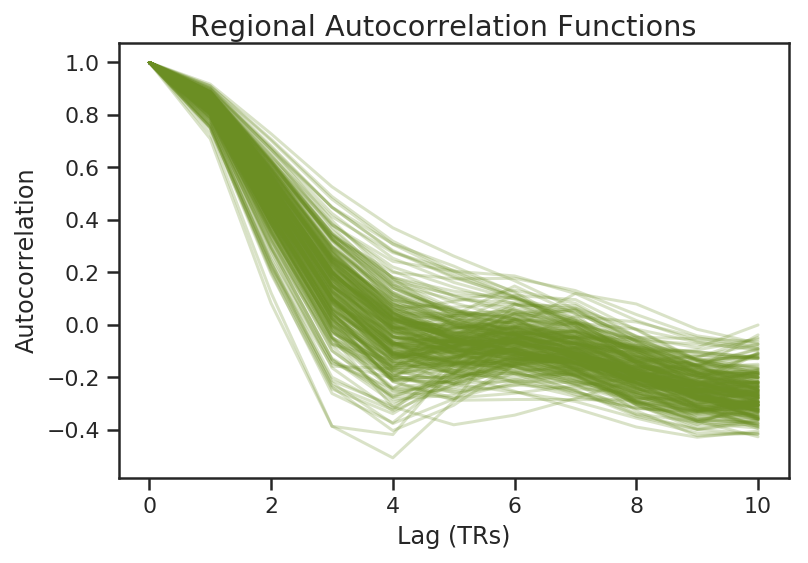

In [12]:
for ROI in range(246):
    fig = plt.plot(range(11), autocorr_range(ts_df[ROI], range(11)), alpha=0.25, color='olivedrab')
plt.xlabel("Lag (TRs)")
plt.ylabel("Autocorrelation")
res = plt.suptitle("Regional Autocorrelation Functions", y=0.93)

### Exponential Fit

Fit an exponential decay function, following Murray et al., 2014.

$$ R(k\Delta) = A\left [ exp(-\frac{k\Delta}{\tau}) + B \right ] $$

Where $k\Delta$ is the lag and $\tau$ is the intrinsic timescale.

In [13]:
from scipy.optimize import curve_fit

In [14]:
def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

In [15]:
def decay(data, ROI, lag_max, show_data=True):
    xvar = list(range(lag_max))
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(data[ROI], xvar))
    plt.plot(xvar, decay_func(xvar, *popt), label="Exponential Fit")
    if show_data:
        plt.plot(xvar, autocorr_range(ts_df[ROI], xvar), label="Autocorrelation Function")
        plt.legend()
        print(popt[1])
   
    return popt[1] # Return the decay constant

Plot exponential fits for all ROIs (limit decay to the first 10 lags).

Text(0.5, 0.93, 'Regional Exponential Decays')

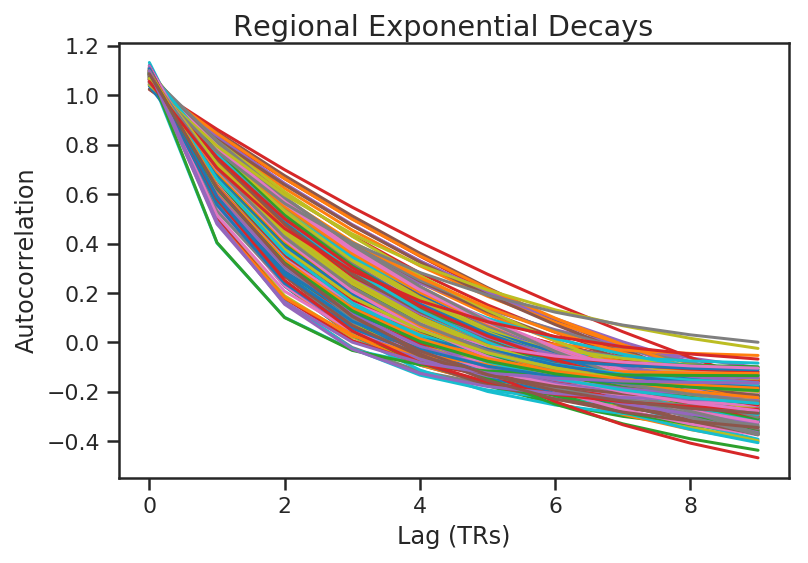

In [16]:
decays_10 = []
for ROI in range(246):
    res = decays_10.append(decay(ts_df, ROI, 10, False))
plt.xlabel("Lag (TRs)")
plt.ylabel("Autocorrelation")
plt.suptitle("Regional Exponential Decays", y=0.93)

ROI 3 is an example of a region with a relatively fast decay (steep slope).

3.2377522146


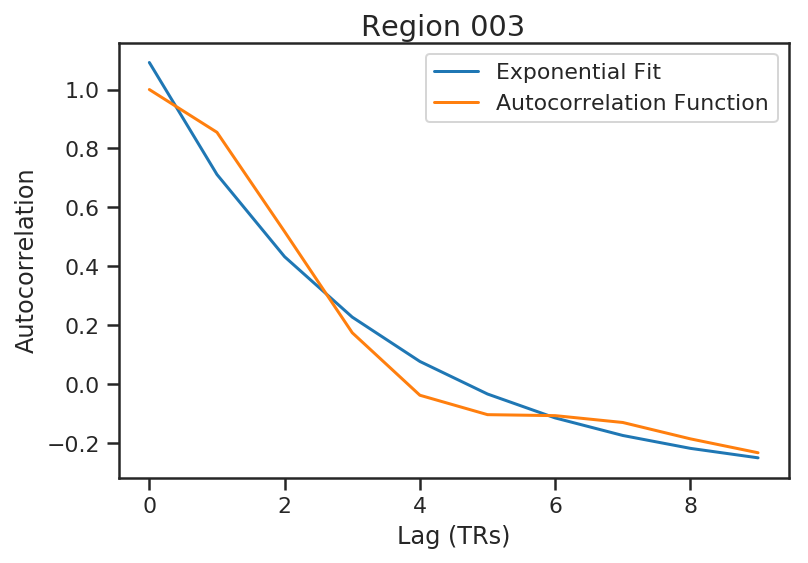

In [18]:
res = decay(ts_df, 2, 10)
plt.xlabel("Lag (TRs)")
plt.ylabel("Autocorrelation")
res = plt.suptitle("Region 003", y=0.93)

ROI 4 is an example of a region with a relatively slow decay (shallow slope).

14.0064643854


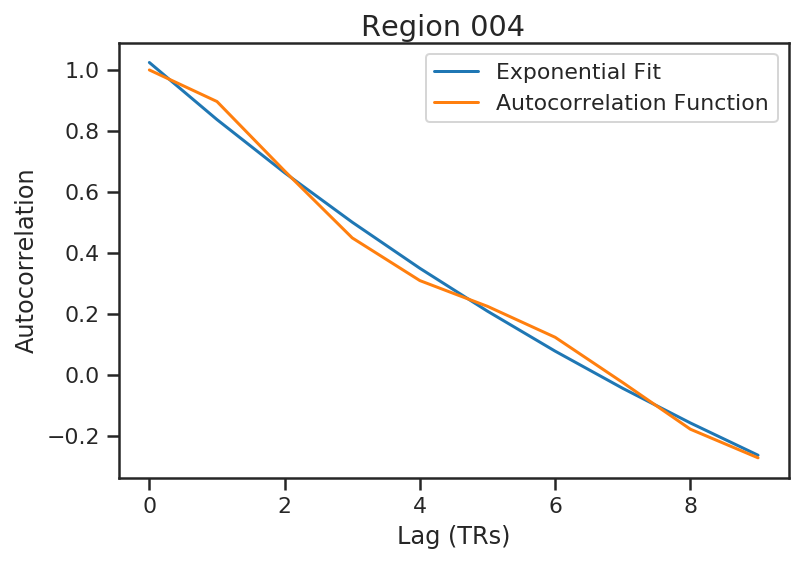

In [19]:
res = decay(ts_df, 3, 10)
plt.xlabel("Lag (TRs)")
plt.ylabel("Autocorrelation")
res = plt.suptitle("Region 004", y=0.93)

Plot the distribution of decays.

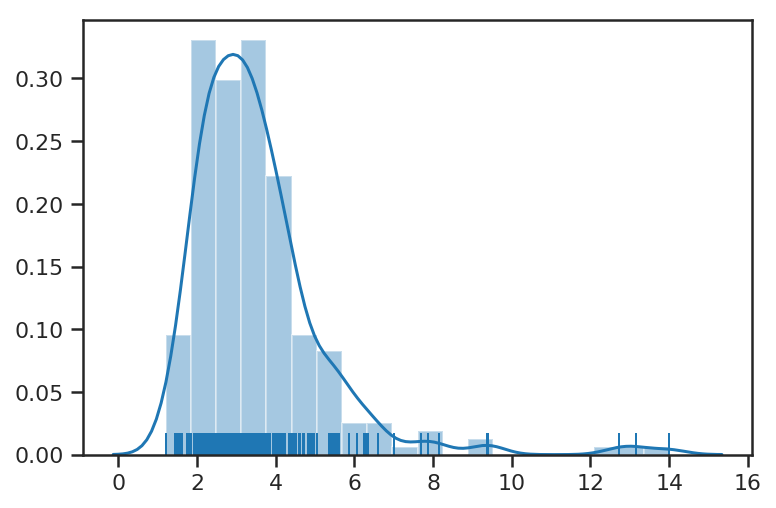

In [21]:
f = sns.distplot(decays_10, bins=20, rug=True)

Do we get similar timescale esimtates if we use the first 20 lags?

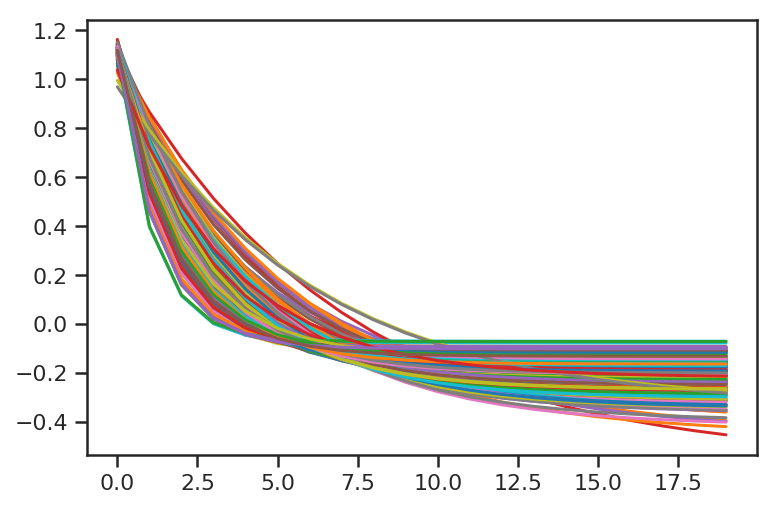

In [22]:
decays_20 = []
for ROI in range(246):
    decays_20.append(decay(ts_df, ROI, 20, False))

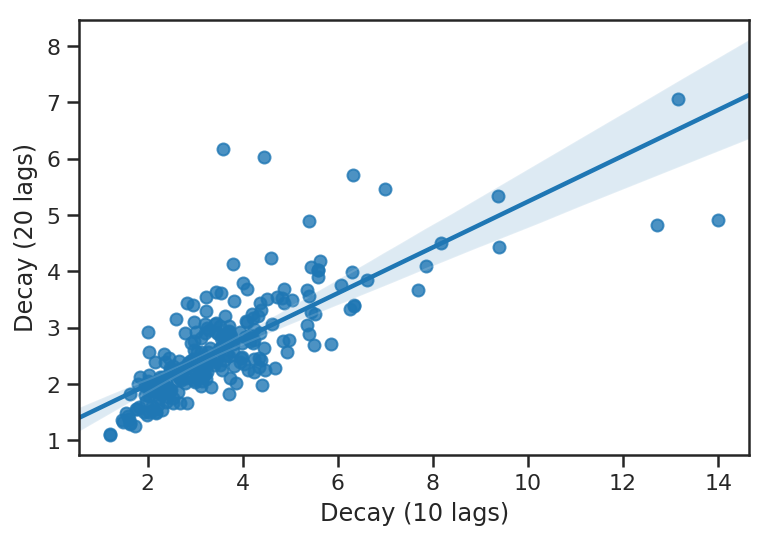

In [23]:
f = sns.regplot(np.array(decays_10), np.array(decays_20))
res = f.set_xlabel('Decay (10 lags)')
res = f.set_ylabel('Decay (20 lags)')

Looks like there is a bit of a long tail. That's interesting.

### Comparing the three measures.

In [26]:
ts_df = pd.DataFrame([decays_10, decays_20, lag1_array])

In [27]:
ts_df = ts_df.T

In [28]:
ts_df.columns = ['decay10', 'decay20', 'lag1']

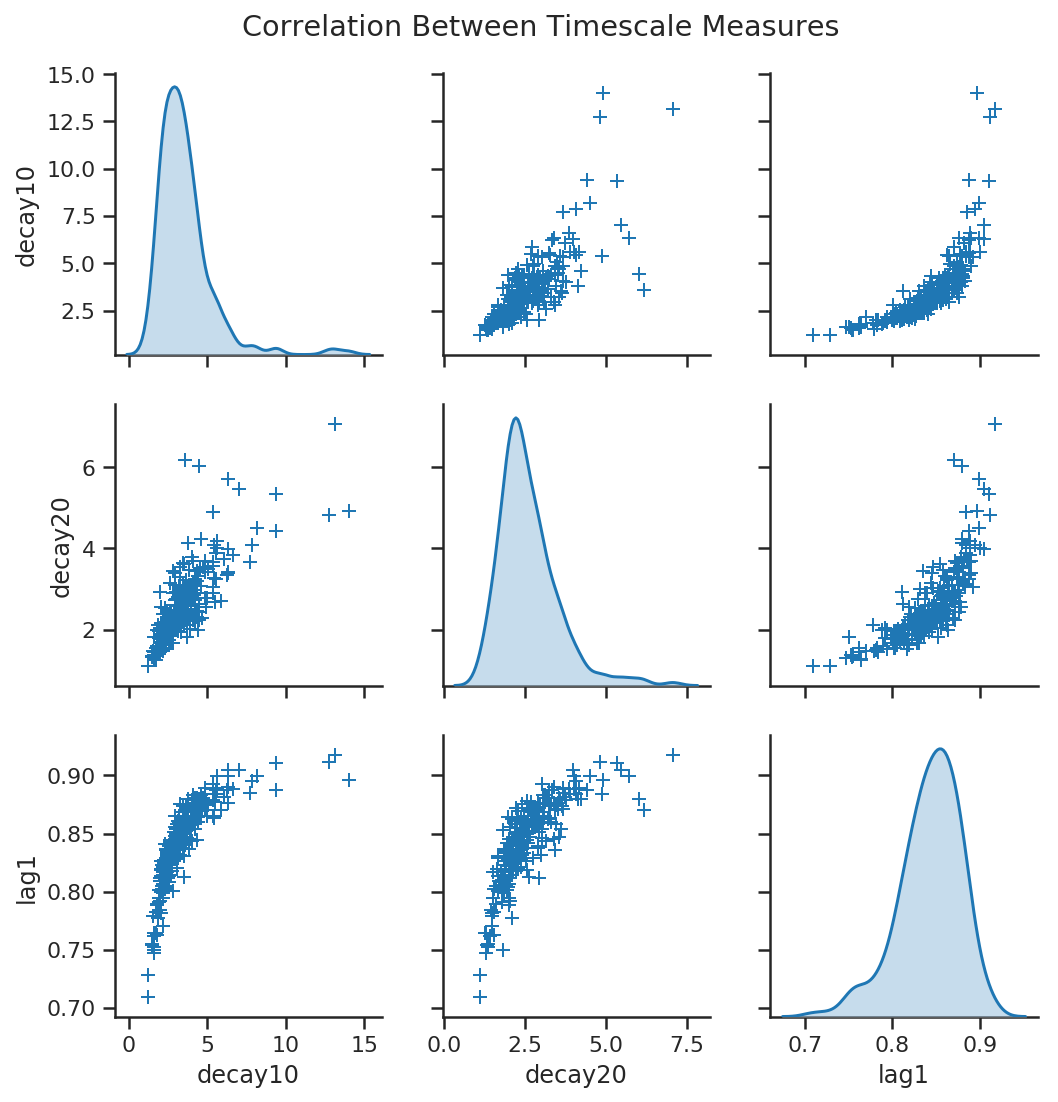

In [30]:
g = sns.pairplot(ts_df, diag_kind='kde', markers='+',
             plot_kws=dict(s=50, edgecolor="b", linewidth=1),
             diag_kws=dict(shade=True))
res = plt.suptitle("Correlation Between Timescale Measures", y=1.02)